# Recurrent Neural Network for Sentiment Analysis

Adapted from http://nbviewer.jupyter.org/github/rasbt/pattern_classification/blob/master/machine_learning/scikit-learn/outofcore_modelpersistence.ipynb

<br>
<br>

## The IMDb Movie Review Dataset

In this section, we will train a simple logistic regression model to classify movie reviews from the 50k IMDb review dataset that has been collected by Maas et. al.

> AL Maas, RE Daly, PT Pham, D Huang, AY Ng, and C Potts. Learning word vectors for sentiment analysis. In Proceedings of the 49th Annual Meeting of the Association for Computational Lin- guistics: Human Language Technologies, pages 142–150, Portland, Oregon, USA, June 2011. Association for Computational Linguistics

[Source: http://ai.stanford.edu/~amaas/data/sentiment/]

The dataset consists of 50,000 movie reviews from the original "train" and "test" subdirectories. The class labels are binary (1=positive and 0=negative) and contain 25,000 positive and 25,000 negative movie reviews, respectively.
For simplicity, I assembled the reviews in a single CSV file.


In [1]:
import re
import collections
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('shuffled_movie_data.csv')
df.tail()

,review,sentiment
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0
49999,I waited long to watch this movie. Also becaus...,1


Let us shuffle the class labels.

In [3]:
df.head().values[0]

array(['In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />"Murder in Greenwich" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and ric

## Generator

First, we define a generator that returns the document body and the corresponding class label:

In [4]:
def stream_docs(path):
    with open(path, 'r') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

To conform that the `stream_docs` function fetches the documents as intended, let us execute the following code snippet before we implement the `get_minibatch` function:

After we confirmed that our `stream_docs` functions works, we will now implement a `get_minibatch` function to fetch a specified number (`size`) of documents:

In [5]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    for _ in range(size):
        text, label = next(doc_stream)
        docs.append(text)
        y.append(label)
    return docs, y

## Preprocessing Text Data

Now, let us define a simple `tokenizer` that splits the text into individual word tokens. Furthermore, we will use some simple regular expression to remove HTML markup and all non-letter characters but "emoticons," convert the text to lower case, remove stopwords, and apply the Porter stemming algorithm to convert the words into their root form.

In [8]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r"it's", " it is", text)
    text = re.sub(r"that's", " that is", text)
    text = re.sub(r"\'s", " 's", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", " will not", text)
    text = re.sub(r"don't", " do not", text)
    text = re.sub(r"can't", " can not", text)
    text = re.sub(r"cannot", " can not", text)
    text = re.sub(r"n\'t", " n\'t", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'m", " am", text)

    text = re.sub('[\W]+', ' ', text.lower())
    text = [w for w in text.split()]
    
    tokenized = [wordnet_lemmatizer.lemmatize(w) for w in text]
    #return text
    return tokenized

Let's give it at try:

In [9]:
tokenizer("This :) is a <br /> test! :-) and I'm not sure what will happens</br>")

['this',
 'is',
 'a',
 'test',
 'and',
 'i',
 'am',
 'not',
 'sure',
 'what',
 'will',
 'happens']

In [10]:
sentences = []
labels    = []
lenghts   = []

doc_stream = stream_docs('shuffled_movie_data.csv')

for idx, review in enumerate(doc_stream):
    list_of_words = tokenizer(review[0])
    sentences.append(list_of_words)
    labels.append(review[1])
    lenghts.append(len(list_of_words))
    sys.stdout.write('\r{:5.2f}%'.format(100*(idx+1)/50000))
sys.stdout.write('\rDone     \n\n')  

Done     



In [11]:
MAXLEN = max(lenghts)
print('Maximun number of words in a review :', MAXLEN)

assert len(sentences) == len(labels) == 50000

Maximun number of words in a review : 2507


In [12]:
MEAN_LEN = int(sum(lenghts)/len(lenghts))
STD_LEN  = (sum((x - MEAN_LEN)**2 for x in lenghts)/ len(lenghts))**0.5
print('MEAN LEN = ', MEAN_LEN)
print('STD  LEN = ', STD_LEN)

MEAN LEN =  236
STD  LEN =  174.83702022169103


In [13]:
from collections import Counter

def bag_words(reviews, vocabulary):
    all_words = []
    for review in reviews:
        all_words += review
    
    count  = [('UNKNOWN', -1)]
    count += Counter(all_words).most_common(vocabulary - 1)
    
    word_dict = {}
    for i in range(len(count)):
        word_dict[count[i][0]] = i
    
    return word_dict, dict(zip(word_dict.values(), word_dict.keys()))

In [14]:
def make_index_sentences(reviews, dictionary, MEAN_LEN):
    ID_sentences = [] 
    for review in reviews:
        ID_sentence = [0 for i in range(MEAN_LEN)]
        for lsen, word in enumerate(review):
            idr = dictionary.get(word, 0)
            if lsen >= MEAN_LEN: break
            else: ID_sentence[lsen] = idr
        ID_sentences.append(ID_sentence)
    return ID_sentences

In [15]:
voc_size         = 10000

In [16]:
word_index, id_toWord = bag_words(sentences, voc_size)

In [17]:
MAX_LEN   = 400

In [18]:
IDreviews = make_index_sentences(sentences, word_index, MAX_LEN)

## Generator for training 

In [19]:
def get_training_set(sentences, labels, lenghts, batch_size):
    N = len(sentences)
    for i in range(0, N, batch_size):
        embeddings = np.array(sentences[i : i + batch_size], dtype = np.int32)
        batch_lebl = np.reshape(np.array(labels[i: i + batch_size] , dtype = np.int32), (-1, 1))
        seq_lenght = np.array(lenghts[i: i + batch_size], dtype = np.int32)
        yield embeddings, batch_lebl, seq_lenght

In [20]:
batch_size = 10
gen = get_training_set(IDreviews, labels, lenghts, batch_size)
batch1, batch2, batch3 = next(gen)
print('review_shape : ', batch1.shape, ', label_shape: ', batch2.shape,', seq_shape : ', batch3.shape)

review_shape :  (10, 400) , label_shape:  (10, 1) , seq_shape :  (10,)


In [21]:
del gen, batch1, batch2, batch3

## Recurrent Neural Network

A recuerrent neural network about two layers of bidirectional LSTMs with dropout, and also two additional dense layers on the output.

In [22]:
import tensorflow as tf

def getWeights(shape):
    initVar = weights = tf.truncated_normal_initializer(stddev=0.1)
    return tf.get_variable('W',
                            dtype = tf.float32,
                            shape = shape,
                            initializer = tf.truncated_normal_initializer(stddev=0.01))

def getBiases(shape):
    initVar = tf.constant(0.0, shape = shape, dtype = tf.float32)
    return tf.get_variable('b',
                            dtype = tf.float32,
                            initializer = initVar)

def RNN(input_rev, vocabulary_size, emb_size, n_hidden, n_dense, batch_size, seq_max_len, seq_len, num_layers, prob):  
    embedding = tf.Variable(tf.random_uniform((vocabulary_size, emb_size), -1, 1))
    embed     = tf.nn.embedding_lookup(embedding, input_rev)
    
    lstms_fw = [tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(n_hidden) for _ in range(num_layers)]
    cell_fw  = tf.contrib.rnn.MultiRNNCell(lstms_fw)

    lstms_bw = [tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(n_hidden) for _ in range(num_layers)]
    cell_bw  = tf.contrib.rnn.MultiRNNCell(lstms_bw)
    
    cell_fw  = tf.nn.rnn_cell.DropoutWrapper(cell_fw, output_keep_prob=prob)
    cell_bw  = tf.nn.rnn_cell.DropoutWrapper(cell_bw, output_keep_prob=prob)

    outputs, states = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                      cell_bw,
                                                      embed,
                                                      sequence_length=seq_len,
                                                      dtype=tf.float32)
    
    index   = tf.range(0, batch_size) * seq_max_len + (seq_len - 1)
    outputs = tf.gather(tf.reshape(outputs, [-1, n_hidden]), index)
    out     = tf.layers.dense(inputs=outputs, units=1)
    res     = tf.sigmoid(out, 'sigmoid')
    return res   

### Parameters

In [26]:
emb_size         = 100
num_hidden_units = 10
num_dense_units  = 10
number_of_layers = 2
seq_max_len      = MAX_LEN

### Hyperparameters

In [38]:
learning_rate  = 0.001
batch_size     = 500
training_steps = 10

### Graph

In [39]:
#X       = tf.placeholder(tf.float32, [None, seq_max_len, input_dim], name = 'input')
X       = tf.placeholder(tf.int32,   [None, seq_max_len], name='input')
seqLen  = tf.placeholder(tf.int32  , [None], name = 'seq_len')
y       = tf.placeholder(tf.int32,   [None, 1], name = 'labels')
tprob   = tf.placeholder_with_default(1.0, shape=())
with tf.variable_scope("RNN", reuse=tf.AUTO_REUSE):
    pred_out = RNN(X, voc_size, emb_size, num_hidden_units, num_dense_units, batch_size, seq_max_len, seqLen, number_of_layers, tprob)

In [40]:
with tf.variable_scope("Train", reuse=tf.AUTO_REUSE):
    #cost       = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.cast(y, dtype=tf.float32), logits = pred_out))
    assert y.shape[1] == pred_out.shape[1]
    
    cost       = tf.losses.mean_squared_error(y, pred_out)
    train_op   = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    pred_class = tf.greater(pred_out,0.5)
    acc_mes    = tf.equal(pred_class, tf.equal(y,1), name = 'correct_pred')
    acc        = tf.reduce_mean(tf.cast(acc_mes, tf.float32), name='accuracy')

### Training

In [41]:
init     = tf.global_variables_initializer()

N = len(sentences)

cross_val = 0.9
cross_div = int(N * cross_val)

X_train = IDreviews[:cross_div]
y_train = labels[:cross_div]
l_train = lenghts[:cross_div]

X_test  = IDreviews[cross_div:]
y_test  = labels[cross_div:]
l_test  = lenghts[cross_div:]

assert len(X_train) == len(y_train) == len(l_train) == cross_div
assert len(X_test)  == len(y_test)  == len(l_test)  == N - cross_div

print('Train Size = ', len(X_train), ', Test Size = ', len(X_test))
train_loss = []
test_acc   = []
test_loss  = []

fmt = 'epoch : {:4d}, train loss = {:4.3f}, test loss = {:4.3f}, test accuracy = {:4.3f}'

Train Size =  45000 , Test Size =  5000


In [42]:
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(init)
    for ep in range(1, training_steps + 1):
        gen = get_training_set(X_train, y_train, l_train, batch_size)
        loss_t = []
        for i in range(1, len(X_train) // batch_size + 1):
            x_batch , y_batch, seq_len_batch = next(gen)
            _, loss = sess.run([train_op, cost], feed_dict={X     : x_batch, 
                                                            y     : y_batch, 
                                                            seqLen: seq_len_batch,
                                                            tprob : 0.5})
            loss_t.append(loss)

        train_loss.append(sum(loss_t)/len(loss_t))

        gen_test = get_training_set(X_test, y_test, l_test, batch_size)
        acc_t    = []
        loss_test= []    
        for i in range(len(X_test) // batch_size):
            x_batch , y_batch, seq_len_batch = next(gen_test)
            accuracy, loss = sess.run([acc, cost], feed_dict={X     : x_batch, 
                                                              y     : y_batch, 
                                                              seqLen: seq_len_batch,
                                                              tprob : 1.0})
            acc_t.append(accuracy)
            loss_test.append(loss)
        test_acc.append(sum(acc_t)/len(acc_t))
        test_loss.append(sum(loss_test)/len(loss_test))

        print(fmt.format(ep, train_loss[-1], test_loss[-1], test_acc[-1]))

epoch :    1, train loss = 0.247, test loss = 0.239, test accuracy = 0.593
epoch :    2, train loss = 0.214, test loss = 0.174, test accuracy = 0.741
epoch :    3, train loss = 0.166, test loss = 0.149, test accuracy = 0.785
epoch :    4, train loss = 0.141, test loss = 0.134, test accuracy = 0.808
epoch :    5, train loss = 0.126, test loss = 0.128, test accuracy = 0.816
epoch :    6, train loss = 0.116, test loss = 0.126, test accuracy = 0.820
epoch :    7, train loss = 0.113, test loss = 0.125, test accuracy = 0.816
epoch :    8, train loss = 0.107, test loss = 0.127, test accuracy = 0.818
epoch :    9, train loss = 0.098, test loss = 0.121, test accuracy = 0.828
epoch :   10, train loss = 0.095, test loss = 0.122, test accuracy = 0.827


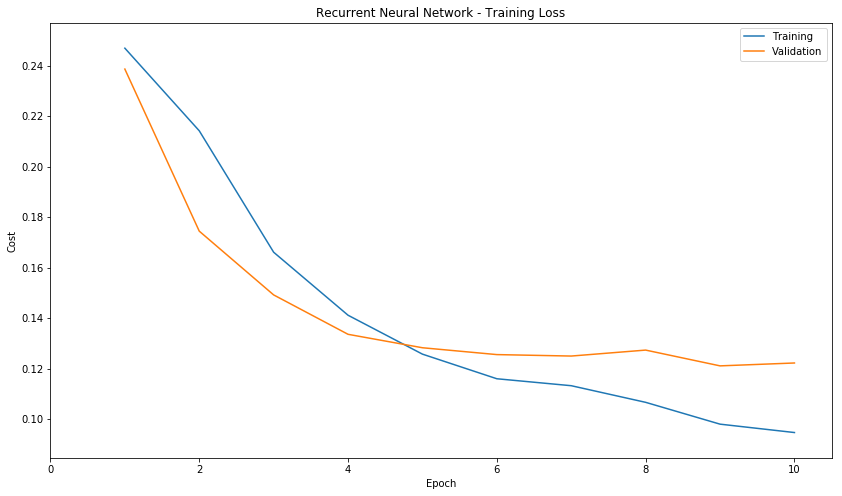

In [43]:
#This lines are for plot error on each epoch

ep  = np.arange(1, training_steps + 1, 1)
fig, ax   = plt.subplots(figsize=(14, 8))
l1, l2    = ax.plot(ep, train_loss, ep, test_loss)
ax.set(xlabel='Epoch', ylabel='Cost', title='Recurrent Neural Network - Training Loss')
ax.axis([0.0, training_steps + 0.5, min(train_loss)-0.01, train_loss[0]+0.01])
plt.legend([l1, l2],["Training","Validation"])
plt.show()

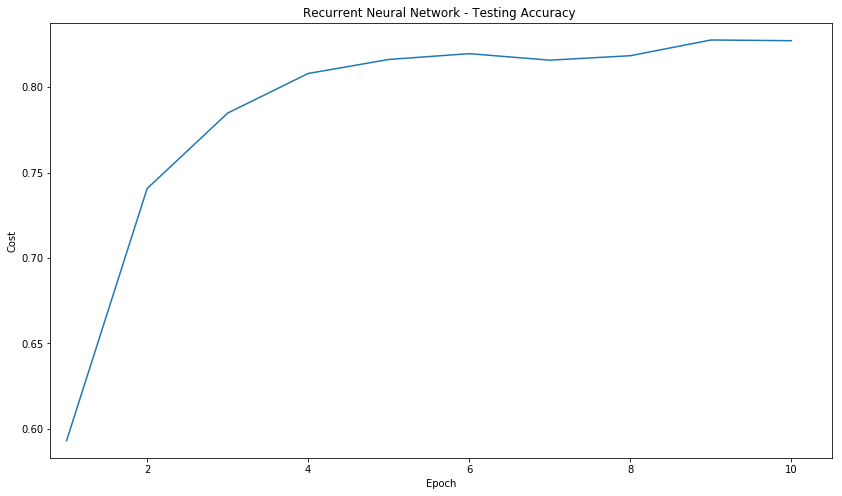

In [44]:
fig, ax = plt.subplots(figsize=(14, 8))
l2      = ax.plot( ep, test_acc)
ax.set(xlabel='Epoch', ylabel='Cost', title='Recurrent Neural Network - Testing Accuracy ')
ax.axis([0.8, training_steps + 0.5, test_acc[0]-0.01, max(test_acc)+0.01])
#plt.legend([l1, l2],["Training","Validation"])
plt.show()